# Leaf Disease Segmentation using U-Net

In this notebook, we focus on the semantic segmentation of plant leaf images to accurately identify and isolate diseased regions.

Unlike classification, which predicts a single label for an image, segmentation provides a pixel-wise mask that highlights the specific areas of interest — in this case, the infected regions of the leaf. This is crucial for applications like:

- Visualizing the spread and severity of disease on a leaf.
- Assisting agronomists in diagnosing plant health.
- Building automated disease treatment systems.

---

## Dataset
For this task, we use the [Leaf Disease Segmentation Dataset](https://www.kaggle.com/datasets/fakhrealam9537/leaf-disease-segmentation-dataset), which contains:
- Leaf images with various diseases.
- Corresponding segmentation masks marking diseased areas.

---

## What you will see in this Notebook:
1. Loading and preprocessing the segmentation dataset.
2. Building a **U-Net model** for semantic segmentation.
3. Training the model to generate precise disease masks.
4. Evaluating model performance using visualization of predicted masks.
5. Saving the best segmentation model for future inference.

---

## Importing necessary libraries 

In [18]:
import os
import glob
import tqdm
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import *
from tensorflow.keras import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

## Data Loading and Preprocessing

In [3]:
root_path = '/kaggle/input/leaf-disease-segmentation-dataset/aug_data/aug_data'

In [4]:
l = os.listdir(root_path)

print(f"\nimages and it's masks dir")
print(l)


images and it's masks dir
['images', 'masks']


In [5]:
images_paths = glob.glob( f'{os.path.join(root_path, "images")}/*.*')
masks_paths = glob.glob( f'{os.path.join(root_path, "masks")}/*.*')

images_paths = sorted(images_paths)
masks_paths = sorted(masks_paths)

In [6]:
len(images_paths), len(masks_paths)

(2940, 2940)

In [8]:
print(f"Total images found: {len(images_paths)}")
print(f"Total masks found: {len(masks_paths)}")
print("-" * 30)
print(f"Image file path 0: {images_paths[0]}")
print(f"Mask file path 0: {masks_paths[0]}")
print(f"\nImage file path 10: {images_paths[10]}")
print(f"Mask file path 10: {masks_paths[10]}")

Total images found: 2940
Total masks found: 2940
------------------------------
Image file path 0: /kaggle/input/leaf-disease-segmentation-dataset/aug_data/aug_data/images/00000_0.jpg
Mask file path 0: /kaggle/input/leaf-disease-segmentation-dataset/aug_data/aug_data/masks/00000_0.png

Image file path 10: /kaggle/input/leaf-disease-segmentation-dataset/aug_data/aug_data/images/00002_0.jpg
Mask file path 10: /kaggle/input/leaf-disease-segmentation-dataset/aug_data/aug_data/masks/00002_0.png


In [10]:
IMG_WIDTH = 224
IMG_HEIGHT = 224
IMG_CHANNELS = 3

In [26]:
seed = 42
np.random.seed(seed)

num_samples = len(images_paths)

X_train = np.zeros((num_samples, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((num_samples, IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool_)

print('Resizing images and masks...')


for i in tqdm.tqdm(range(num_samples)):
    img_path = images_paths[i]
    mask_path = masks_paths[i]
    
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    
    X_train[i] = (img)

    mask = cv2.imread(mask_path, 0)
    mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH, 1), mode='constant', preserve_range=True)
  
    Y_train[i] = (mask )

print("\nProcessing complete.")
print(f"Images array shape: {X_train.shape}")
print(f"Masks array shape: {Y_train.shape}")

Resizing images and masks...


100%|██████████| 2940/2940 [06:52<00:00,  7.13it/s] 


Processing complete.
Images array shape: (2940, 224, 224, 3)
Masks array shape: (2940, 224, 224, 1)


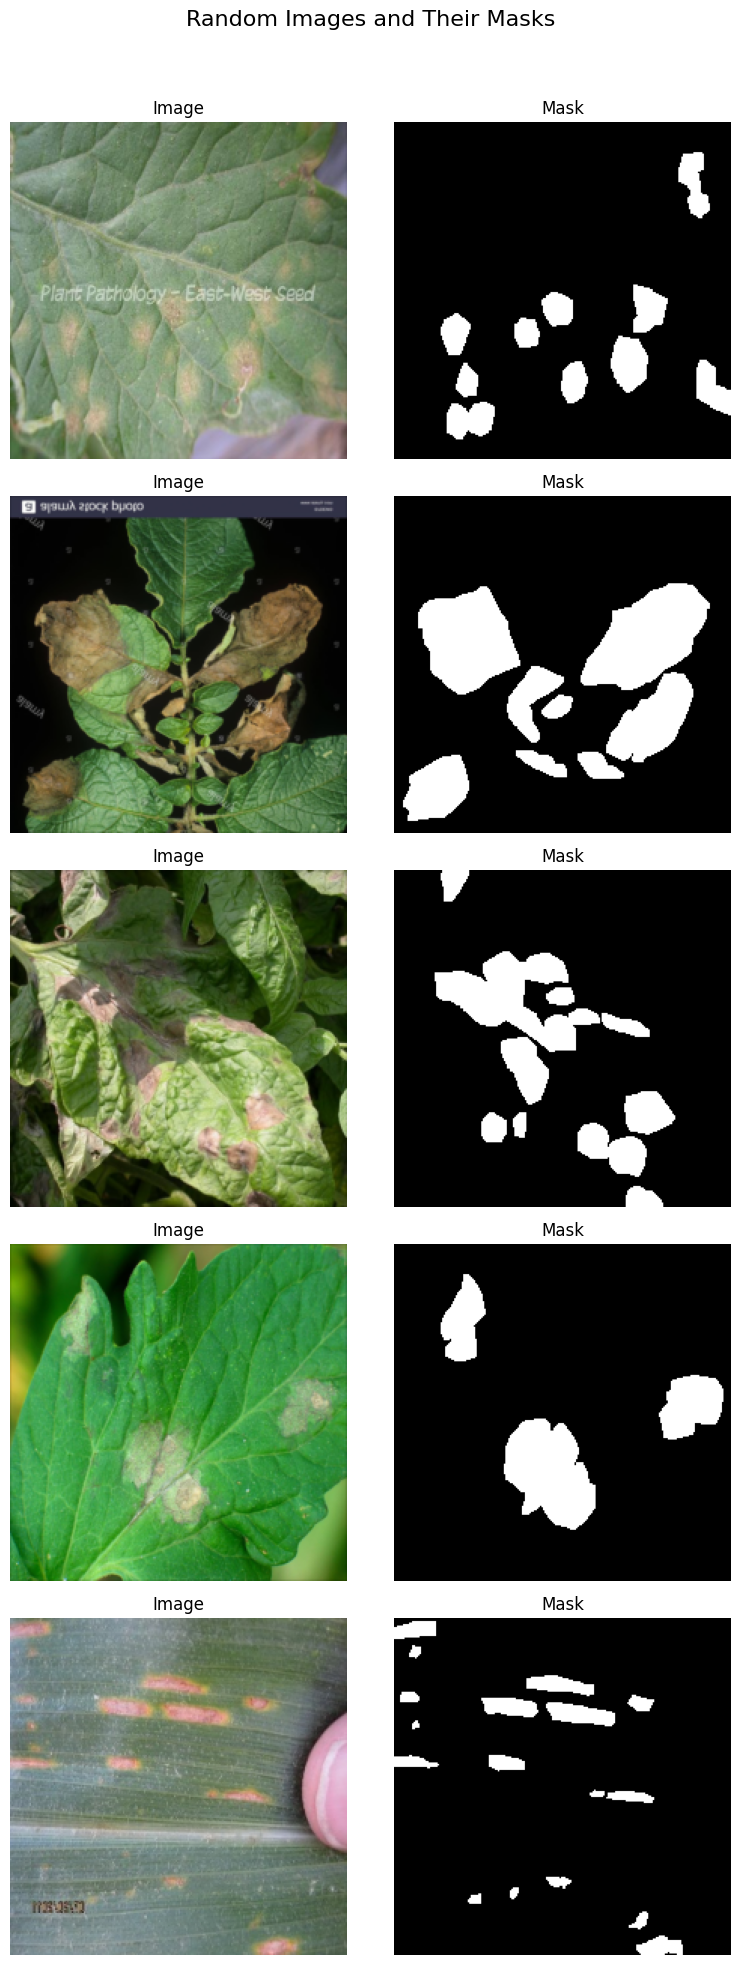

In [19]:
# Visualizing some images:

N_ROWS = 5

fig, axes = plt.subplots(N_ROWS, 2, figsize=(8, N_ROWS * 4))
fig.suptitle("Random Images and Their Masks", fontsize=16)

for i in range(N_ROWS):
    random_idx = np.random.randint(low=0, high=len(X_train))
    img_i = X_train[random_idx]
    mask_i = Y_train[random_idx]

    axes[i, 0].imshow(img_i)
    axes[i, 0].set_title("Image")
    axes[i, 0].axis('off') 
    
    axes[i, 1].imshow(mask_i, cmap="gray")
    axes[i, 1].set_title("Mask")
    axes[i, 1].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.96]) 
plt.show()

In [31]:
Y_train.shape

(2940, 224, 224, 1)

In [47]:
# Data Splitting:

X = X_train
y = Y_train

X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, random_state=42
)

del X_train_val,y_train_val

In [48]:
print(f"Training images shape: {X_train.shape}")
print(f"Training masks shape: {y_train.shape}")
print("-" * 30)
print(f"Validation images shape: {X_val.shape}")
print(f"Validation masks shape: {y_val.shape}")
print("-" * 30)
print(f"Test images shape: {X_test.shape}")
print(f"Test masks shape: {y_test.shape}")

Training images shape: (1764, 224, 224, 3)
Training masks shape: (1764, 224, 224, 1)
------------------------------
Validation images shape: (588, 224, 224, 3)
Validation masks shape: (588, 224, 224, 1)
------------------------------
Test images shape: (588, 224, 224, 3)
Test masks shape: (588, 224, 224, 1)


In [49]:
X_train = X_train.astype('float32') / 255.0
X_val = X_val.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0
y_train = y_train.astype('float32')
y_val = y_val.astype('float32')
y_test = y_test.astype('float32')

# Verify the new data types
print(f"X_train dtype: {X_train.dtype}")
print(f"y_train dtype: {y_train.dtype}")

X_train dtype: float32
y_train dtype: float32


## U-Net

### *Building*

In [50]:
def unet(input_shape=(224,224,3),num_classes=1):
    NAME = 'unet_1_simple_model'
    
    inputs = Input(input_shape)

    # Encoder
    c1 = Conv2D(32, (3, 3), padding='same')(inputs)
    c1 = BatchNormalization()(c1)
    c1 = Activation('relu')(c1)
    c1 = Conv2D(32, (3, 3), padding='same')(c1)
    c1 = BatchNormalization()(c1)
    c1 = Activation('relu')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(64, (3, 3), padding='same')(p1)
    c2 = BatchNormalization()(c2)
    c2 = Activation('relu')(c2)
    c2 = Conv2D(64, (3, 3), padding='same')(c2)
    c2 = BatchNormalization()(c2)
    c2 = Activation('relu')(c2)
    p2 = MaxPooling2D((2, 2))(c2)


    # Bottleneck
    b = Conv2D(128, (3, 3), padding='same')(p2)
    b = BatchNormalization()(b)
    b = Activation('relu')(b)
    b = Conv2D(128, (3, 3), padding='same')(b)
    b = BatchNormalization()(b)
    b = Activation('relu')(b)

    # Decoder
    u3 = UpSampling2D((2, 2))(b)
    u3 = Conv2D(64, (3, 3), padding='same')(u3)
    u3 = BatchNormalization()(u3)
    u3 = Activation('relu')(u3)
    u3 = concatenate([u3, c2])
    c7 = Conv2D(64, (3, 3), padding='same')(u3)
    c7 = BatchNormalization()(c7)
    c7 = Activation('relu')(c7)
    c7 = Conv2D(64, (3, 3), padding='same')(c7)
    c7 = BatchNormalization()(c7)
    c7 = Activation('relu')(c7)

    u4 = UpSampling2D((2, 2))(c7)
    u4 = Conv2D(32, (3, 3), padding='same')(u4)
    u4 = BatchNormalization()(u4)
    u4 = Activation('relu')(u4)
    u4 = concatenate([u4, c1])
    c8 = Conv2D(32, (3, 3), padding='same')(u4)
    c8 = BatchNormalization()(c8)
    c8 = Activation('relu')(c8)
    c8 = Conv2D(32, (3, 3), padding='same')(c8)
    c8 = BatchNormalization()(c8)
    c8 = Activation('relu')(c8)

    outputs = Conv2D(1, (1,1), activation='sigmoid') (c8)

    model = Model(inputs=inputs, outputs=outputs)
    return model


In [51]:
def dice_coefficient(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)


def iou_metric(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

### *Training*

In [52]:
model = unet()
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_39 (Conv2D)  │ (None, 224, 224,  │        896 │ input_layer_3[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 224, 224,  │        128 │ conv2d_39[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_36       │ (None, 224, 224,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_40 (Conv2D)  │ (None, 224, 224,  │      9,248 │ activation_36[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 224, 224,  │        128 │ conv2d_40[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_37       │ (None, 224, 224,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 112, 112,  │          0 │ activation_37[0]… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_41 (Conv2D)  │ (None, 112, 112,  │     18,496 │ max_pooling2d_6[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_41[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_38       │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_42 (Conv2D)  │ (None, 112, 112,  │     36,928 │ activation_38[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_42[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_39       │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 56, 56,    │          0 │ activation_39[0]… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_43 (Conv2D)  │ (None, 56, 56,    │     73,856 │ max_pooling2d_7[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        512 │ conv2d_43[0][0] 

 Total params: 520,673 (1.99 MB)

 Trainable params: 519,201 (1.98 MB)

 Non-trainable params: 1,472 (5.75 KB)

In [59]:
model.compile(optimizer = 'adam',
              loss = dice_loss, 
              metrics = ['accuracy', dice_coefficient, iou_metric])

In [62]:
# CALLBACK 1:

checkpoint_dir = 'model_checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

checkpoint = ModelCheckpoint(
    filepath = os.path.join(checkpoint_dir, 'best_segmentation_model.h5'),
    monitor = 'val_iou_metric',  
    save_best_only = True,         
    save_weights_only = False,      
    mode = 'max',                  
    verbose = 1)

# CALLBACK 2:

early_stopping = EarlyStopping(
    monitor = 'val_iou_metric',
    min_delta = 0.001,
    patience = 8,
    verbose = 1,
    mode='max',
    restore_best_weights = True)

# CALLBACK 3:

learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_iou_metric',
                                            patience = 3,
                                            verbose=1,
                                            factor=0.3, 
                                            min_lr=0.000001)

CALLBACKS = [checkpoint, early_stopping, learning_rate_reduction]

In [63]:
unet_history = model.fit(X_train, y_train, epochs= 20, callbacks = CALLBACKS,
                         validation_data= (X_val,y_val))

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step - accuracy: 0.8971 - dice_coefficient: 0.7230 - iou_metric: 0.5677 - loss: 0.2770
Epoch 1: val_iou_metric improved from -inf to 0.52935, saving model to model_checkpoints/best_segmentation_model.h5
56/56 ━━━━━━━━━━━━━━━━━━━━ 25s 447ms/step - accuracy: 0.8970 - dice_coefficient: 0.7231 - iou_metric: 0.5677 - loss: 0.2769 - val_accuracy: 0.8978 - val_dice_coefficient: 0.6902 - val_iou_metric: 0.5294 - val_loss: 0.3100 - learning_rate: 0.0010
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step - accuracy: 0.8982 - dice_coefficient: 0.7340 - iou_metric: 0.5808 - loss: 0.2660
Epoch 2: val_iou_metric improved from 0.52935 to 0.56617, saving model to model_checkpoints/best_segmentation_model.h5
56/56 ━━━━━━━━━━━━━━━━━━━━ 24s 437ms/step - accuracy: 0.8982 - dice_coefficient: 0.7340 - iou_metric: 0.5808 - loss: 0.2660 - val_accuracy: 0.9058 - val_dice_coefficient: 0.7217 - val_iou_metric: 0.5662 - val_loss: 0.2807 - learning_rate: 0.0010
Epoch

In [64]:
os.makedirs('results', exist_ok=True)

model.save('results/best_segmentation_model.h5')
model.save_weights('results/best_segmentation_model_weights.weights.h5')

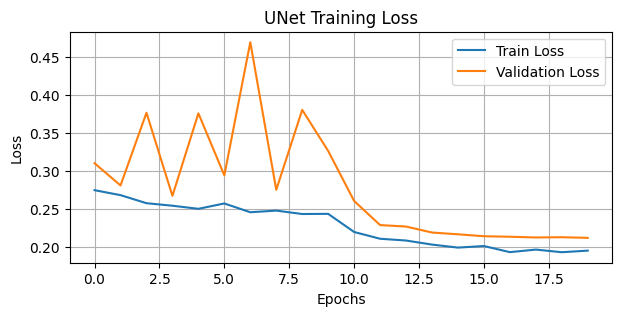

In [66]:
plt.figure(figsize=(7, 3))
plt.grid(True)
plt.title("UNet Training Loss")
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.plot(unet_history.history['loss'], label='Train Loss')
plt.plot(unet_history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

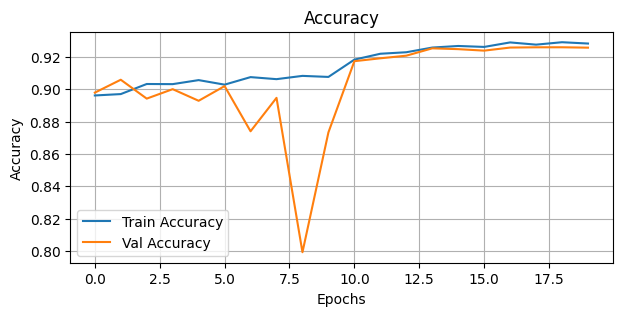

In [67]:
plt.figure(figsize=(7, 3))
plt.grid(True)
plt.title("Accuracy")
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.plot(unet_history.history['accuracy'], label='Train Accuracy')
plt.plot(unet_history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.show()

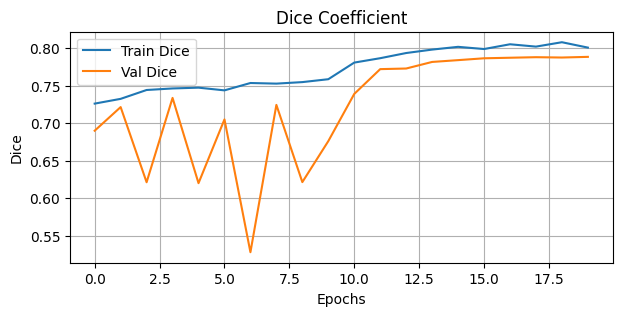

In [69]:
plt.figure(figsize=(7, 3))
plt.grid(True)
plt.title("Dice Coefficient")
plt.ylabel('Dice')
plt.xlabel('Epochs')
plt.plot(unet_history.history['dice_coefficient'], label='Train Dice')
plt.plot(unet_history.history['val_dice_coefficient'], label='Val Dice')
plt.legend()
plt.show()

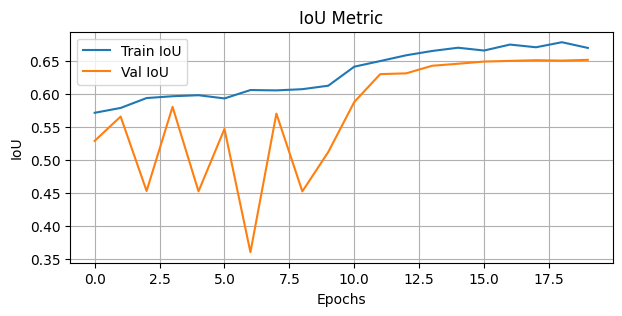

In [70]:
plt.figure(figsize=(7, 3))
plt.grid(True)
plt.title("IoU Metric")
plt.ylabel('IoU')
plt.xlabel('Epochs')
plt.plot(unet_history.history['iou_metric'], label='Train IoU')
plt.plot(unet_history.history['val_iou_metric'], label='Val IoU')
plt.legend()
plt.show()

### *Evaluation*

In [75]:
y_pred = model.predict(X_test)

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step 


In [76]:
y_pred = (y_pred > 0.4).astype(np.uint8)

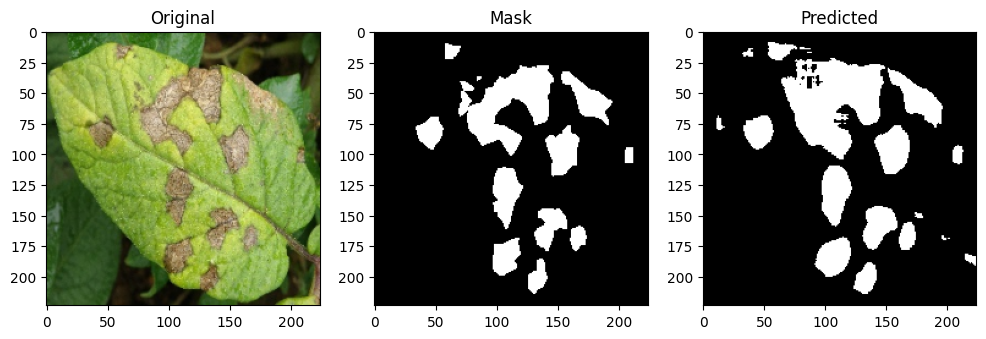

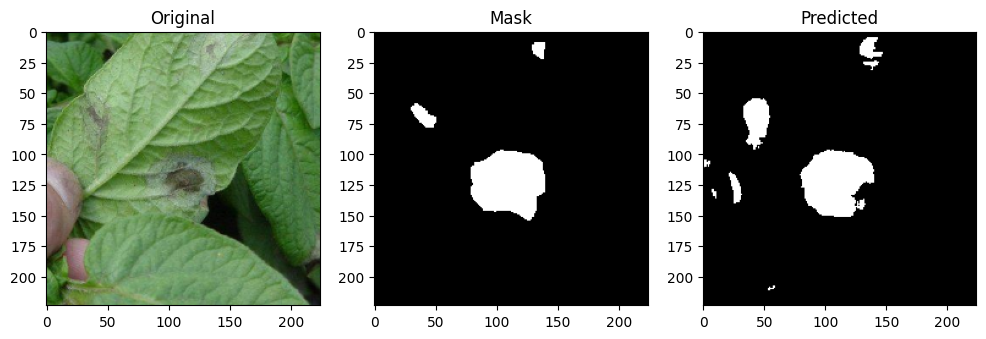

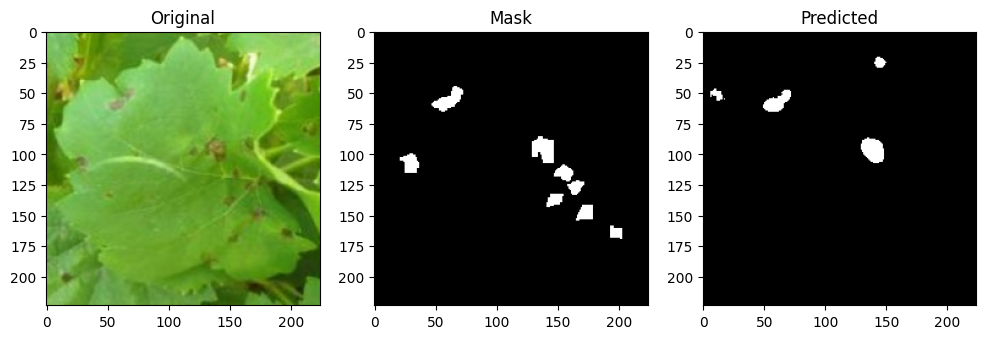

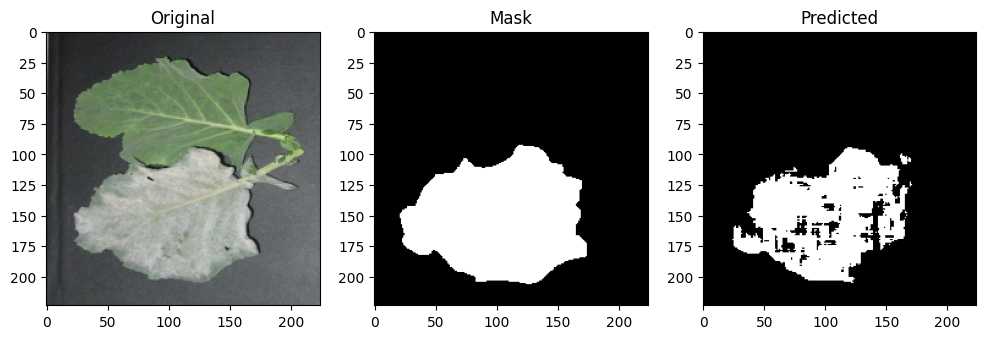

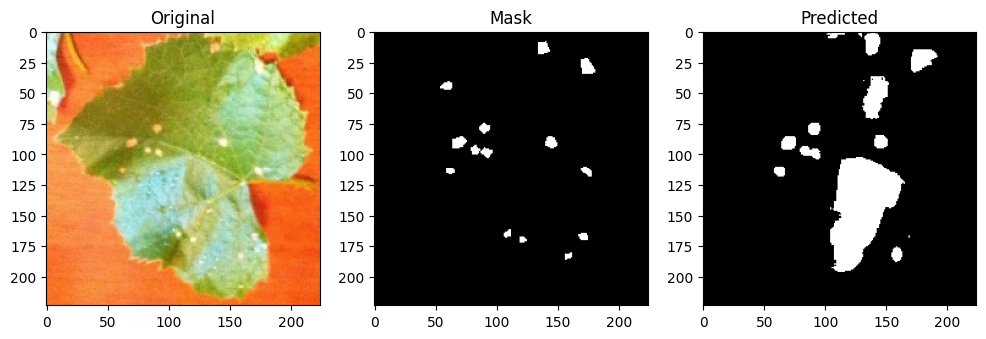

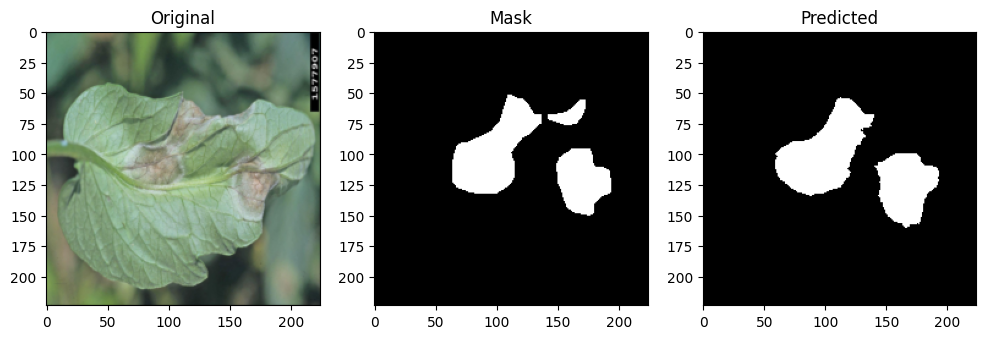

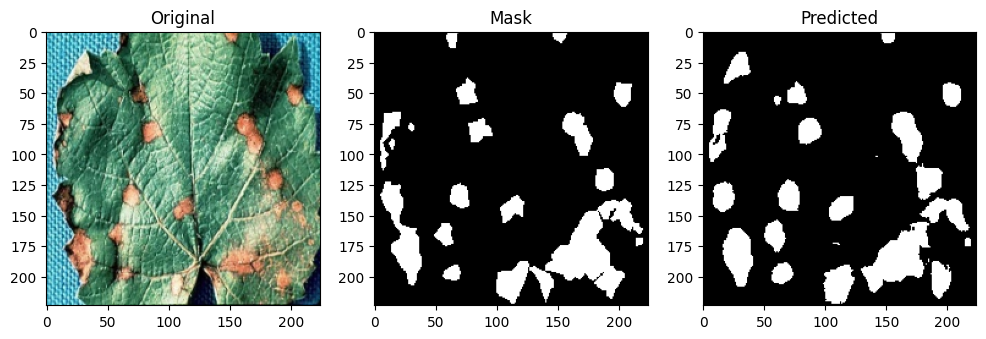

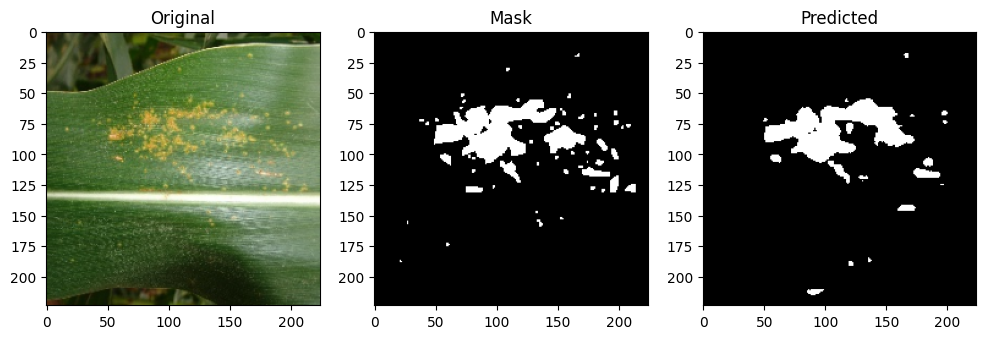

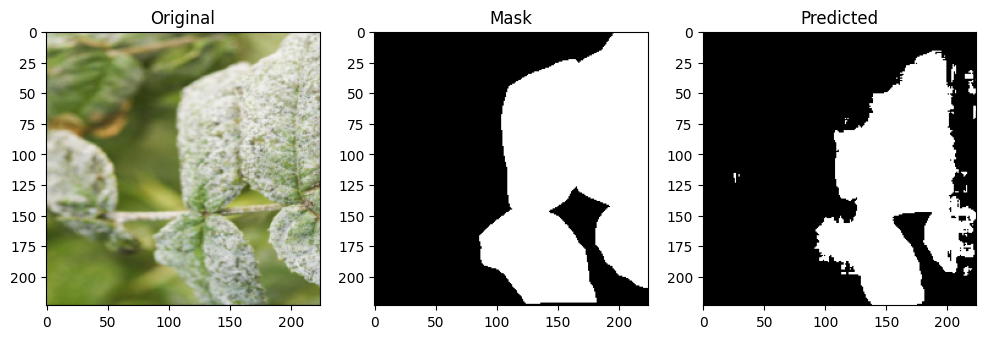

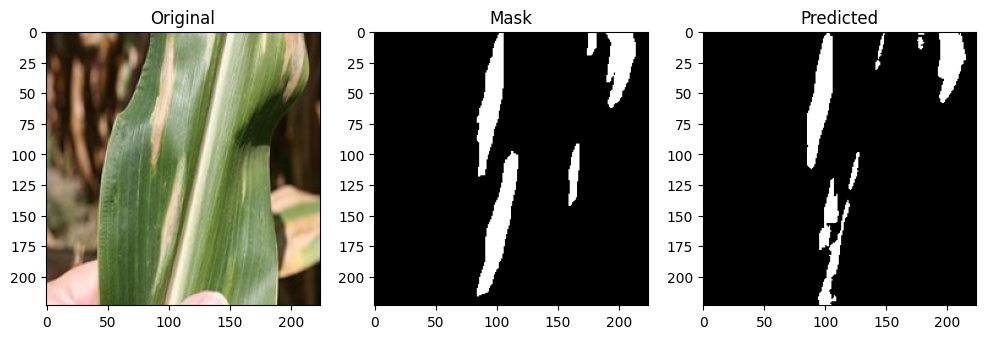

In [77]:
for i in range(10):
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 3, 1)
    plt.title('Original')
    plt.imshow(X_test[i], cmap='gray')

    plt.subplot(1, 3, 2)
    plt.title('Mask')
    plt.imshow(y_test[i].squeeze(), cmap='gray')

    plt.subplot(1, 3, 3)
    plt.title('Predicted')
    plt.imshow(y_pred[i].squeeze(), cmap='gray')

    plt.show()